# Machine Learning (Scikit-learn, XGBoost, LightGBM, CatBoost): Regressor

In this document, the performance of 8 different Machine Learning (ML) algorithms are
compared to solve the regression problem, this is, to predict the value of a continuous variable, in this case, it is the fuel consumption of a car. The following algorithms are implemented:

Algorithm 1: Lasso (Linear regressions with L1 regularization).

Algorithm 2: Ridge (Linear regressions with L2 regularization).

Algorithm 3: DecisionTreeRegressor.

Algorithm 4: RandomForestRegressor.

Algorithm 5: GradientBoostingRegressor.

Algorithm 6: XGBRegressor (XGBoost library).

Algorithm 7: LGBMRegressor (LightGBM library).

Algorithm 8: CatBoostRegressor (CatBoost library).

Finally, the best model is trained and saved to make predictions in production.

## Exploratory data analysis (EDA)

In [141]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [142]:
# Read DataFrame
df = pd.read_csv('../data/raw/auto_cons_us.csv', sep=',', header=0)

# Show DataFrame
df.head(3)

,Fuel consumption,# of cylinders,Engine displacement,Engine power,Weight,Acceleration,Year,Origin
0,13,8,5,130.0,1589,12.0,2005,US
1,16,8,6,165.0,1675,11.5,2005,US
2,13,8,5,150.0,1559,11.0,2005,US


Column 'Fuel consumption' will be renamed.

In [143]:
# Rename column
df = df.rename(columns={'Fuel consumption': 'target'})

# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   target               398 non-null    int64  
 1   # of cylinders       398 non-null    int64  
 2   Engine displacement  398 non-null    int64  
 3   Engine power         392 non-null    float64
 4   Weight               398 non-null    int64  
 5   Acceleration         398 non-null    float64
 6   Year                 398 non-null    int64  
 7   Origin               398 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 25.0+ KB


Format of all columns is correct.

## Data preprocessing
Data preprocessing consist of:
1. Filling null values and dropping duplicates.
2. Processing outliers and multicollinearity.
3. Converting categorical variables into binary ones.
4. Standardizing (scaling) the data.

### Fill null values and drop duplicates

In [144]:
# Verify the number of null values per column
df.isna().sum()

target                 0
# of cylinders         0
Engine displacement    0
Engine power           6
Weight                 0
Acceleration           0
Year                   0
Origin                 0
dtype: int64

There are a few null values, they can be deleted.

In [145]:
# Delete null values
df = df.dropna()

# Verify the number of null values per column
df.isna().sum()

target                 0
# of cylinders         0
Engine displacement    0
Engine power           0
Weight                 0
Acceleration           0
Year                   0
Origin                 0
dtype: int64

In [146]:
# Delete duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# Show duplicate rows
print(df.duplicated().sum())

0


### Process outliers and multicollinearity
Outliers are deleted (from percentile 5 to the percentile 95).

In [147]:
# Limit outliers to percentile 5 or percentile 95
for col in df.drop(['target','Origin'],axis=1).columns:
    percentile05 = df[col].quantile(0.05)
    percentile95 = df[col].quantile(0.95)
for index,value in df[col].items():
    if value < percentile05:
        df.loc[index,col] = percentile05
    if value > percentile95:
        df.loc[index,col] = percentile95

A box plot is shown to verify if there exist outliers (no considerable outliers).

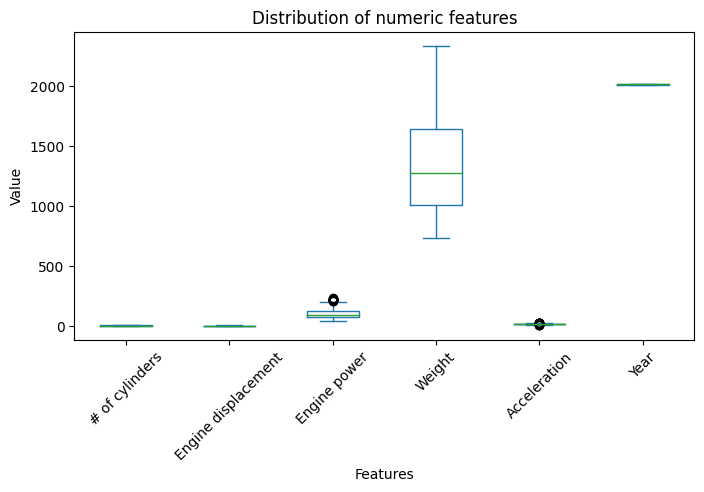

In [148]:
# Box plot
df.drop('target',axis=1).plot(kind='box', figsize=[8,4],
title='Distribution of numeric features', xlabel='Features', ylabel='Value')
plt.xticks(rotation=45)
plt.show()

In order to see multicollinearity, a heatmap is shown (excluding column 'Origin').

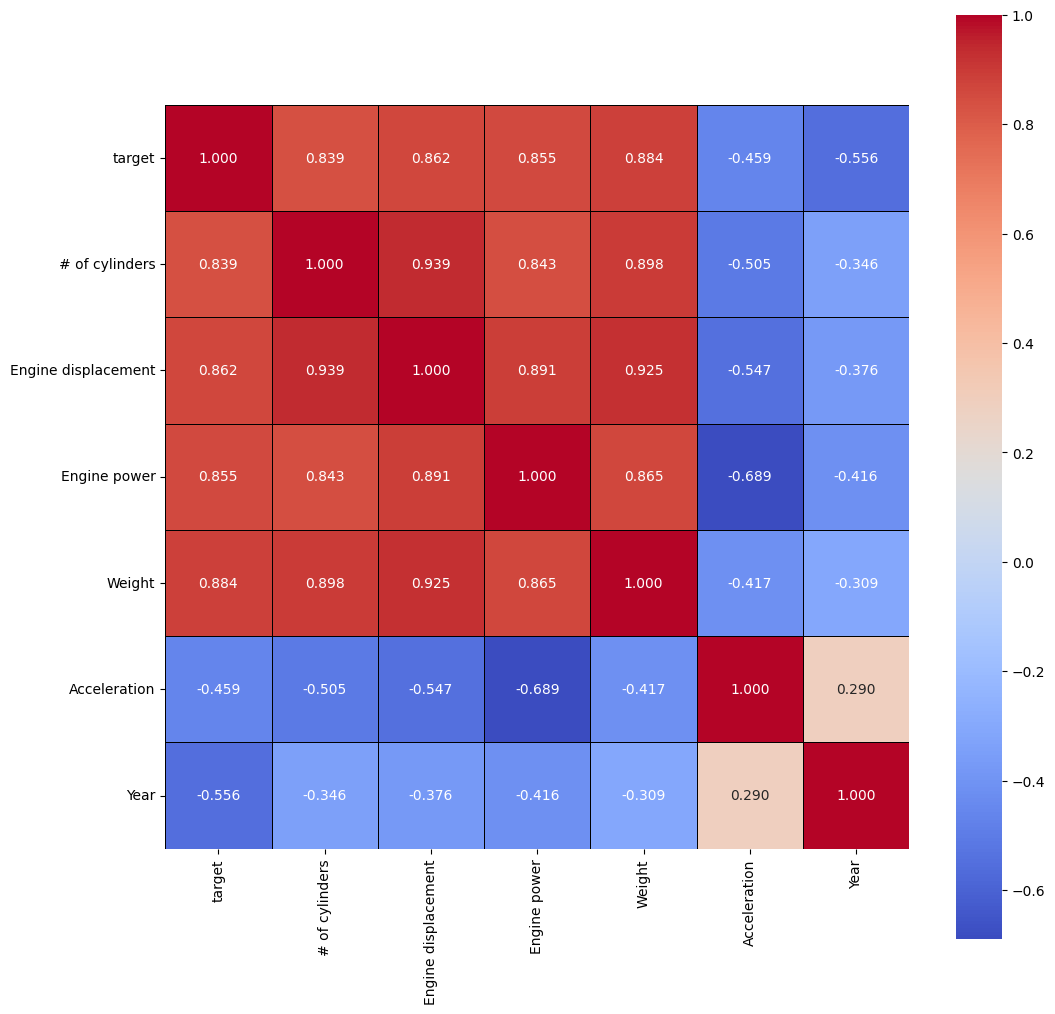

In [149]:
# Correlation matrix
cm = df.drop('Origin',axis=1).corr()

# Heatmap
plt.figure(figsize = (12,12))
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', fmt='.3f',
annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.show()

Column 'target' is correlated to all columns and '# of cylinders' is correlated to	'Engine displacement'.

**Remark:** Processed data is now saved.

In [150]:
# Save processed data
df.to_csv('../data/processed/auto_cons_us_processed.csv', index=False)

# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   target               392 non-null    int64  
 1   # of cylinders       392 non-null    int64  
 2   Engine displacement  392 non-null    int64  
 3   Engine power         392 non-null    float64
 4   Weight               392 non-null    int64  
 5   Acceleration         392 non-null    float64
 6   Year                 392 non-null    int64  
 7   Origin               392 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 24.6+ KB


### Convert categorical variables

In [151]:
# Show the columns of the DataFrame
print(df.columns)

# Convert categorical variables to dummy variables
df = pd.get_dummies(df)
print(df.head(3))

Index(['target', '# of cylinders', 'Engine displacement', 'Engine power',
       'Weight', 'Acceleration', 'Year', 'Origin'],
      dtype='object')
   target  # of cylinders  Engine displacement  Engine power  Weight  \
0      13               8                    5         130.0    1589   
1      16               8                    6         165.0    1675   
2      13               8                    5         150.0    1559   

   Acceleration  Year  Origin_Asia  Origin_Europe  Origin_US  
0          12.0  2005        False          False       True  
1          11.5  2005        False          False       True  
2          11.0  2005        False          False       True  


Two columns were added.

### Data standarization

In [152]:
# Obtain characteristic matrix (x) and objective variable (y)
x = df.drop('target', axis=1)
y = df['target']

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
x, y, test_size=0.2, random_state=0)

# Train the StandardScaler by using 'x_train', then transform 'x_train' and 'x_test'
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

## Models belonging to Scikit-Learn library
Five different models will be created.

In [153]:
# Define the regression models
models = [Lasso(), Ridge(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor()]

def mape(y_true, y_pred):
    '''Function to calculate Mean Absolute Percentage Error (MAPE)'''
    y_error = y_true - y_pred
    y_error_abs = np.array([abs(x) for x in y_error])
    y_true_abs = np.array([abs(x) for x in y_true])
    perc_error_abs = y_error_abs / y_true_abs
    mape = perc_error_abs.sum() / len(y_true)
    return mape

def make_prediction(m, x_train, y_train, x_test, y_test):
    m.fit(x_train, y_train)
    y_pred = m.predict(x_test)
    print('MAE:{:.2f} MSE:{:.2f} MAPE:{:.2f} R2:{:.2%}'
          .format(mean_absolute_error(y_test, y_pred),
                    mean_squared_error(y_test, y_pred),
                    mape(y_test, y_pred),
                    r2_score(y_test, y_pred)))

In [154]:
# Iterate through the models and make predictionsRandomForestRegress
for i in models:
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

Lasso()
MAE:1.41 MSE:3.53 MAPE:0.14 R2:78.28%
Ridge()
MAE:1.05 MSE:1.93 MAPE:0.09 R2:88.14%
DecisionTreeRegressor()
MAE:1.18 MSE:3.00 MAPE:0.10 R2:81.53%
RandomForestRegressor()
MAE:0.91 MSE:1.58 MAPE:0.08 R2:90.26%
GradientBoostingRegressor()
MAE:0.95 MSE:1.63 MAPE:0.08 R2:89.96%


**Conclusion:** 'Random Forest Regressor' and 'Gradient Boosting Regressor' obtained better results. Both will be compared with the gradient boosting models in the next section.

**Remark:** The column names and feature importances coefficients (for Random Forest Regressor)
are displayed to show which features most impact the algorithm's verdict.

In [155]:
# Show features
print(x.columns)

# Feature weights
print(models[3].feature_importances_)

Index(['# of cylinders', 'Engine displacement', 'Engine power', 'Weight',
       'Acceleration', 'Year', 'Origin_Asia', 'Origin_Europe', 'Origin_US'],
      dtype='object')
[0.04295356 0.12751178 0.19999839 0.51990818 0.03240075 0.07376656
 0.00097146 0.00103255 0.00145676]


Definitively, 'Weight' (feature importances coefficient = 0.5) is the most important factor that impacts the fuel consumption.

## Models with Gradient Boosting that do not belong to Scikit-Learn library

In [156]:
# Read DataFrame
df = pd.read_csv('../data/processed/auto_cons_us_processed.csv', sep=',', header=0)

# Show DataFrame
print(df.head(3))

   target  # of cylinders  Engine displacement  Engine power  Weight  \
0      13               8                    5         130.0    1589   
1      16               8                    6         165.0    1675   
2      13               8                    5         150.0    1559   

   Acceleration  Year Origin  
0          12.0  2005     US  
1          11.5  2005     US  
2          11.0  2005     US  


Ensemble models like RandomForestRegressor and XGBRegressor work better with label encoding, so label encoding will be implemented in this section.

In [157]:
label_encoders = {}

# Apply LabelEncoder to categorical columns
for col in df.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    label_encoders[col] = encoder

# Save label encoders
joblib.dump(label_encoders, '../models/rg_label_enc.pkl')

['../models/rg_label_enc.pkl']

In [158]:
# Obtain characteristic matrix (x) and objective variable (y)
x = df.drop('target', axis=1)
y = df['target']

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
x, y, test_size=0.2, random_state=0)

# Train the StandardScaler by using 'x_train', then transform 'x_train' and 'x_test'
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

# Save scaler
joblib.dump(scaler, '../models/rg_scaler.pkl')

['../models/rg_scaler.pkl']

In [159]:
# Define the regression models
models = [RandomForestRegressor(criterion='squared_error',
                                max_depth=30,n_estimators=100, random_state=0),
          GradientBoostingRegressor(loss='squared_error', random_state=0),
          XGBRegressor(objective='reg:squarederror',
                       n_estimators=100, learning_rate=0.1, random_state=0),
          LGBMRegressor(objective='regression', metric='rmse', verbose=0,
                        n_estimators=10, learning_rate=0.1, random_state=0),
          CatBoostRegressor(loss_function="RMSE", iterations=50, verbose=10,
                            depth=10, cat_features=None, random_state=0),
          ]

In [160]:
# Iterate through the models and make predictionsRandomForestRegress
for i in models:
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

RandomForestRegressor(max_depth=30, random_state=0)
MAE:0.94 MSE:1.64 MAPE:0.08 R2:89.89%
GradientBoostingRegressor(random_state=0)
MAE:0.93 MSE:1.55 MAPE:0.08 R2:90.44%
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)
MAE:0.97 MSE:1.70 MAPE:0.09 R2:89.52%
LGBMRegressor(metric='rmse', n_estimators=10, objective

GradientBoostingRegressor obtained better performance, it will be used to make predictions in production in the next section.

In [161]:
# Save the trained model
joblib.dump(models[1], '../models/rg_GradientBoosting_model.joblib')
print("Model saved successfully.")

Model saved successfully.


## Make predictions in production

In [162]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

In [163]:
# Load the scaler, label encoders, and trained model
label_Encoder = joblib.load('../models/rg_label_enc.pkl')
loaded_scaler = joblib.load('../models/rg_scaler.pkl')
loaded_model = joblib.load('../models/rg_GradientBoosting_model.joblib')
print("Model and objects loaded successfully.")

Model and objects loaded successfully.


In [164]:
# Read DataFrame
df = pd.read_csv('../data/processed/auto_cons_us_processed.csv', sep=',', header=0)

# Show DataFrame
print(df.head(3))

   target  # of cylinders  Engine displacement  Engine power  Weight  \
0      13               8                    5         130.0    1589   
1      16               8                    6         165.0    1675   
2      13               8                    5         150.0    1559   

   Acceleration  Year Origin  
0          12.0  2005     US  
1          11.5  2005     US  
2          11.0  2005     US  


In [165]:
# Prediction 1, the result is aproximately 17
prediction1 = {
    '# of cylinders': 8,
    'Engine displacement': 6,
    'Engine power': 170,
    'Weight': 1690,
    'Acceleration': 12,
    'Year': 2005,
    'Origin': 'US'
}

In [166]:
def preprocess_data(df:pd.DataFrame):
    '''Function to preprocess new data for prediction'''
    # Apply the imported label_Encoder
    for col, encoder in label_Encoder.items():
        if col in df.select_dtypes(include=['object']).columns:
            try:
                df[col] = encoder.transform(df[col])
            except ValueError as e:
                raise ValueError(f"Error when transforming column '{col}'.")
    # Scale the data
    df = loaded_scaler.transform(df)
    return df

def make_prediction(single_case:dict):
    # Convert to DataFrame
    single_case_df = pd.DataFrame([single_case])
    
    # Preprocess the data
    processed_single_case = preprocess_data(single_case_df)

    # Make prediction
    prediction = loaded_model.predict(processed_single_case)
    
    print(f'Prediction: {prediction[0]:.2f}')

In [167]:
make_prediction(prediction1)

Prediction: 16.99
